<img src="images/econ140R_logo.png" width="200" />

In the following cell, please type your name and SID:

In the cell below, please write out the [Honor Code](https://teaching.berkeley.edu/berkeley-honor-code) to reaffirm you are abiding by it.

Did you work with other students? List them below. Please write your answers in your own words, not in theirs.

<h1>ECON 140R - Problem Set 4</h1>

<h2>INSTRUCTIONS</h2>

Please step through this problem set, copying and pasting code as needed, and run the code to produce output. Answer the questions asked, which appear in <font color="blue">blue font</font>. You will earn 100% of the credit on this problem set for <b>completing</b> it with working code and coherent answers. Answers do not need to be correct for full credit.

Throughout, <b>you may consult outside sources like the paper below or other commentary</b>, but your analysis should be in your own words. We will not run TurnItIn software on this Problem Set, but as usual, you should not borrow phrases without attribution or commit "mosaic plagiarism."

<h2>Background</h2>

In this problem set we will examine the `injury` dataset within the Wooldridge repository, which includes measures of workers' compensation utilization and worker characteristics in Kentucky and Michigan around 1980. The data were collected by the [National Council on Compensation Insurance (NCCI)](https://www.ncci.com/pages/default.aspx) and analyzed by [Meyer, Viscusi, and Durbin (1995)](https://www-jstor-org.libproxy.berkeley.edu/stable/2118177).

The scenarios in Kentucky (KY) and Michigan (MI) were similar, although of course the two states differed in terms of industries, incomes, and other characteristics. Both states <i>raised the maximum weekly benefit</i> that workers could receive, by a large amount: from \\$131 to \\$217 or by 66% in KY, and from \\$181 to \\$307 or 70% in MI. Although high inflation rates during this period ate away some of the real value of these increases, they were comfortably high even after adjusting for inflation.

<i>What effect did this policy change have, if any, on benefit claiming behavior?</i>

<b>Workers' compensation</b> plans differ in implementation across states, but the general structure replaces wages when a workplace injury prevents working. An injured worker's weekly workers' comp payment is a function of the worker's wage, via a "replacement rate," above a floor and up to a ceiling. The floor grants low-paid workers a minimum weekly insurance payout, and the ceiling places a cap on the total amount paid. In between, workers are paid perhaps two-thirds or 66.67% of their weekly wages, the replacement rate for Kentucky cited in the study.

As Meyer, Viscusi, and Durbin discuss, the most common type of payment is for temporary total disabilities, where a person is unable to work but is expected to recover fully and return to work. As they describe on p. 324, "temporary total claims have no fixed duration; their length is determined by the injured worker, his or her doctor, the employer, and its insurer."
    
Shown below, Figure 1 from [Meyer, Viscusi, and Durbin (1995)](https://www-jstor-org.libproxy.berkeley.edu/stable/2118177) illustrates this point and also the change associated with the increases in the maximum in Kentucky and Michigan in this time period.

<img src = "images/meyer-viscusi-durbin-aer95-fig1.png" width = 400/>

In [40]:
library(tidyverse)
library(haven)
library(dplyr)
install.packages('wooldridge')

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)



It turns out that this handy command stops __R__ from defaulting to scientific notation. 

In [41]:
options(scipen=999)

<hr>

Let's load up and look at the data.

In [42]:
library("wooldridge")
data(injury, package = "wooldridge")
head(injury)

,durat,afchnge,highearn,male,married,hosp,indust,injtype,age,prewage,⋯,head,neck,upextr,trunk,lowback,lowextr,occdis,manuf,construc,highlpre
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,1,1,1,0,1,3,1,26,404.9500,⋯,1,0,0,0,0,0,0,0,0,6.003764
2,1,1,1,1,1,0,3,1,31,643.8250,⋯,1,0,0,0,0,0,0,0,0,6.467427
3,84,1,1,1,1,1,3,1,37,398.1250,⋯,1,0,0,0,0,0,0,0,0,5.986766
4,4,1,1,1,1,1,3,1,31,527.8000,⋯,1,0,0,0,0,0,0,0,0,6.268717
5,1,1,1,1,1,0,3,1,23,528.9375,⋯,1,0,0,0,0,0,0,0,0,6.270870
6,1,1,1,1,1,0,3,1,34,614.2500,⋯,1,0,0,0,0,0,0,0,0,6.420402


As usual, you can call the code below to pull up the documentation for the dataset, which reveals the variable descriptions.

In [43]:
?injury

As is customary inside the helpful `wooldridge` repository, a lot of variables have already been constructed for us. Variables with a leading lowercase "L" are natural logs of things. It is very common to log variables like prices or incomes, because they typically have long right tails. Let us have a look at a key variable: `durat`, the duration in weeks of the workers' compensation claim.

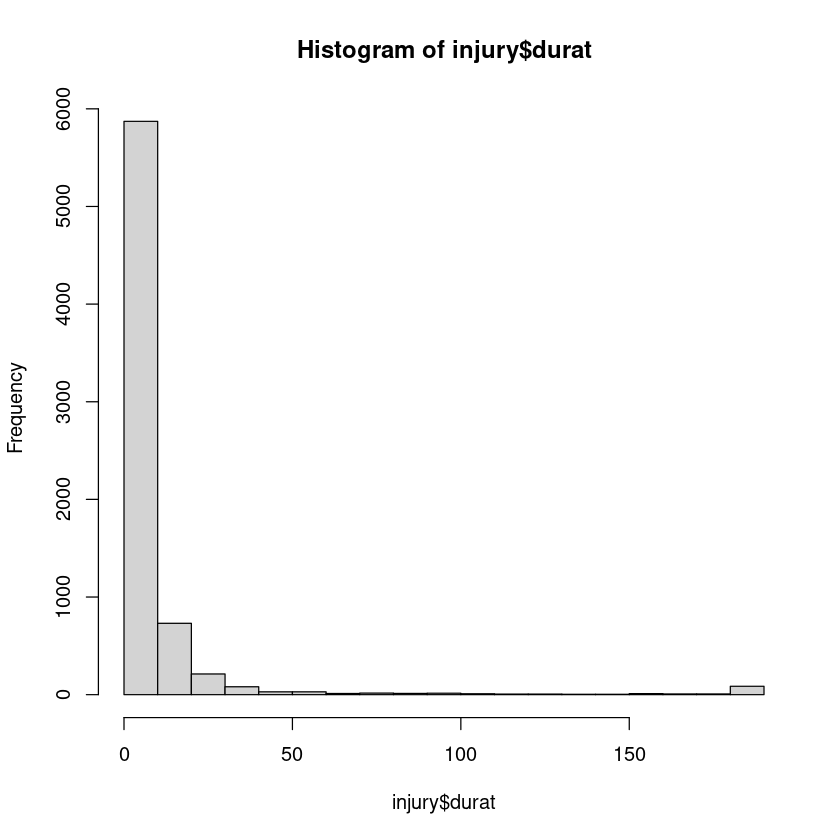

In [44]:
hist(injury$durat)

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

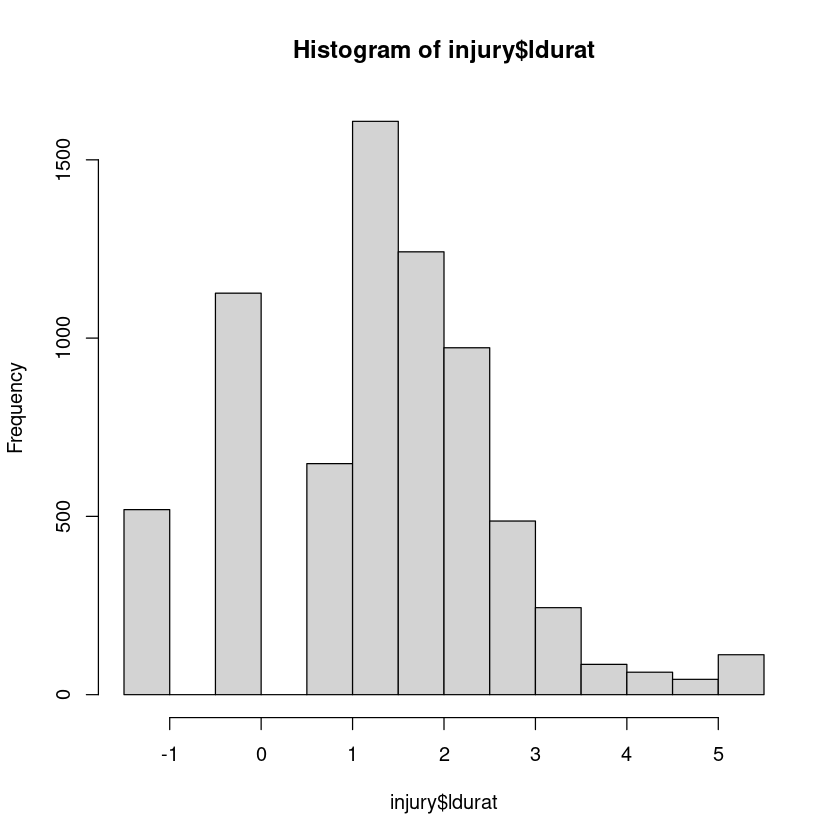

In [45]:
# Here, look at the histogram of the natural logarithm of claim duration
hist(injury$ldurat)

<font color="blue">
    <h3>
    Question 1</h3>
    One of these histograms looks like a bell curve, or somewhat normally distributed, and one does not. Which one looks reasonably like a bell curve?
</font>

It seems pretty clear that the log of workers' comp duration, $ldurat$ here, is the one that looks more like a bell curve. The level of the duration, $durat$, has a very long right tail. 

<hr>

<h2>Ordinary Least Squares</h2>

Let us therefore use a regression model to estimate the somewhat-normally-distributed variable as a function of things that we think matter for the duration of workers' comp benefits. Obvious choices for the determinants of benefit duration are the nature of the injury, the worker's industry, and the worker's age. Less obvious choices are the earnings class of the worker, gender, and marital status. 

If the nature of the injury were the only thing that drove what is ostensibly medical decisionmaking, one would expect that things like marital status should not matter for benefits duration unless they somehow proxied for health status. (As a parent of small children, I can attest that injuries appear to hurt a lot more than they used to now that I have additional care responsibilities, but that could also just be an age effect!)

First things first. Let us remove one Kentuckian who is listed as 98 years old. The next oldest is 81 and then two workers are listed at age 80. This suggests to me that the 98yo is actually an unrecoded "missing data" problem. Missings are often coded as 98 or 99, or 998 or 998.

In [46]:
# Drop an apparent miscoding using subset()
injury1 <- subset(injury, age < 98)

Here is our first regression model:

$$
ldurat_{i} = \alpha + \beta^a \ age_{i} + \beta^m \ male_{i}
+ \sum_k \beta^k \ injury^k_{i} 
+ \sum_\eta \beta^\eta \ industry^\eta_{i} 
+ \epsilon_{i}
$$

The right-hand-side variables are <i>age</i> in years; an indicator variable for <i>male</i> identity; and sets of indicator variables for the type of injury by body location: <i>head</i>, <i>neck</i>, <i>upextr</i> for upper extremities, <i>trunk</i>, <i>lowback</i> for lower back, <i>lowextr</i> for lower extremities; and type, <i>occdis</i> for occupational disease. We also have indicators for industry: <i>manuf</i> for manufacturing, and <i>construc</i> for construction.

Let us estimate the model on a subset of the data: for Kentucky in the period before the policy change around 1980. The indicator variable <i>afchnge</i> equals 1 after the policy change and 0 before it.

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [47]:
# Alter the code below to use subset() to grab the observations 
# for which afchnge == 0 & ky == 1
injury1_ky_before <- subset(injury1, afchnge == 0 & ky == 1)

Now run the code below using that subset of the data we created.

In [48]:
ldurat_reg1 <- lm(ldurat ~ age + male + 
                  head + neck + upextr + trunk +
                  lowback + lowextr + occdis + 
                  manuf + construc, 
                  data = injury1_ky_before)
summary(ldurat_reg1)


Call:
lm(formula = ldurat ~ age + male + head + neck + upextr + trunk + 
    lowback + lowextr + occdis + manuf + construc, data = injury1_ky_before)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0724 -0.8097  0.0906  0.7602  4.6156 

Coefficients:
             Estimate Std. Error t value           Pr(>|t|)    
(Intercept)  1.213276   0.158787   7.641 0.0000000000000291 ***
age          0.008986   0.001864   4.820 0.0000015072541349 ***
male        -0.029186   0.056462  -0.517            0.60525    
head        -0.784364   0.180576  -4.344 0.0000144908376280 ***
neck         0.196896   0.234080   0.841            0.40034    
upextr      -0.330951   0.143325  -2.309            0.02101 *  
trunk       -0.092390   0.153364  -0.602            0.54694    
lowback     -0.136818   0.143896  -0.951            0.34178    
lowextr     -0.290428   0.144736  -2.007            0.04488 *  
occdis      -0.176420   0.299309  -0.589            0.55562    
manuf       -0.152807   0.055769  -2

<font color="blue">
    <h3>
    Question 2</h3>
    Look at the regression output above and describe what you see. 
    Do older workers spend more time on workers' comp, conditional on gender, injury location, and industry? Does that make sense to you?
    Of the coefficients on the various body parts of the injury, do any of the results seem strange? (Of these listed, what body part is arguably the most important? <i>This question probably does not have a single correct answer, but one really stood out to me.</i>)
</font>

This first model shows us several significant coefficients on demographics, on the body location of the injury, and the industry of the worker. Age is significantly associated with longer log benefits duration, to the tune of about 0.9 percent per year, call it 1 percent per year. This seems pretty reasonable, if also substantial. A lot of things rise like this with age; mortality risk does, for example. 

It is really odd IMHO that head injuries appear to be those associated with the shortest of all durations! The coefficient is $-0.78$ and strongly significant. That is a 78 percent ("log points" as they say) reduction in benefits duration. I suppose this might reflect a sad truth about how medical and regular society have treated head injuries and concussions: if one cannot see an injury, and it does not prevent picking up objects or walking, then it might not be viewed as an injury.

<hr>

Now let us examine a model where we add an indicator for being married, $marr_i$, and an indicator of having high earnings, $highearn_{i}$. The precise threshold of earnings is a little unclear; it is in the neighborhood of \\$350 per week, and [Meyer, Viscusi, and Durbin (1995)](https://www-jstor-org.libproxy.berkeley.edu/stable/2118177) discuss it in footnote 17. The regression model becomes:

$$
ldurat_{i} = \alpha + \beta^{h} \ highearn_{i} + \beta^{marr} \ married_{i} 
+ \beta^a \ age_{i} + \beta^m \ male_{i}
+ \sum_k \beta^k \ injury^k_{i} 
+ \sum_\eta \beta^\eta \ industry^\eta_{i} 
+ \epsilon_{i}
$$


<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [60]:
ldurat_reg2 <- lm(ldurat ~ highearn + married + 
                  age + male +
                  head + neck + upextr + trunk +
                  lowback + lowextr + occdis + 
                  manuf + construc, 
                  data = injury1_ky_before)
summary(ldurat_reg2)


Call:
lm(formula = ldurat ~ highearn + married + age + male + head + 
    neck + upextr + trunk + lowback + lowextr + occdis + manuf + 
    construc, data = injury1_ky_before)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0450 -0.7997  0.1009  0.7764  4.5067 

Coefficients:
             Estimate Std. Error t value           Pr(>|t|)    
(Intercept)  1.222035   0.157789   7.745 0.0000000000000133 ***
highearn     0.177395   0.053930   3.289            0.00102 ** 
married      0.096388   0.055298   1.743            0.08143 .  
age          0.006357   0.001999   3.180            0.00149 ** 
male        -0.104564   0.061128  -1.711            0.08727 .  
head        -0.827477   0.179773  -4.603 0.0000043545604449 ***
neck         0.126297   0.236140   0.535            0.59280    
upextr      -0.322520   0.141247  -2.283            0.02248 *  
trunk       -0.112187   0.151770  -0.739            0.45985    
lowback     -0.195774   0.142048  -1.378            0.16825    
lowextr   

<font color="blue">
    <h3>
    Question 3</h3>
    Look at the regression output above and describe what you see. 
    What is the coefficient on $highearn$? Is it statistically significant? Recalling the units of the left-hand-side variable, state what the coefficient on $highearn$ means in terms of the duration of workers' comp between two injured Kentuckians who are observationally identical except that one is high-earning.
    </font>

The coefficient is about $0.18$, and it is statistically significant. That means the high-earning injured Kentuckian receives workers' comp benefits 18 pecent longer, on average, with other things equal. 

<hr>

<font color="blue">
    <h3>
    Question 4</h3>
    Does this result surprise you, as an economist? Do you think it would surprise a typical person? 
    </font>

As economists, we are probably not surprised by this result. We are trained to view choices as determined by marginal costs traded off against marginal benefits. There might be two reasons to expect high-earning workers to take bnenefits longer, other things equal. Mayeb you can think of other reasons too. One reason we might expect benefits duration to be longer among high earners is because their money benefits are higher on average, up to the cap of course. The second is because high earners are probably wealthier, their marginal utility of (earned) income is probably lower, so the incentive to return to working is lower.

I think this probably would surprise a typical person, who is likely to believe that doctors and beneficiaries would set benefits duration based soleley on medical conditions.

<hr>

<h2>Difference in differences</h2>

The raising of the benefit cap around 1980 may have had no effect on benefits claiming if claiming behavior were unrelated to earnings. But claiming behavior clearly was related to earnings, as we have just seen. Because the cap was only a constraint for high earners and not for low earnings, a natural approach to explore is <b>difference-in-differences (DID)</b> estimation.

<font color="blue">
    <h3>
    Question 5</h3>
    According to <i>Mastering Metrics</i> and class discussion, what is the assumption underlying DID? Describe and discuss in this context, where unfortunately it is not directly testable in these data. Take a stand about whether you think DID is appropriate or not for this problem. 
    </font>

The only assumption that DID requires is <b>parallel trends</b>. As long as the $y$-variable for both treatment and control groups is trending the same way, in a parallel fashion, before treatment, then the counterfactual approach in DID makes sense. In the counterfactual, we use the experience of the control group to project what would have happened to the treatment group without the treatment.

It is hard to know what to expect in the data, but perhaps the most obvious thing to expect is nothing, both for high earners and low earners. We know that the benefit cap had not been changed for a while, suggesting that things were probably in steady state. One would expect parallel trends in that case. Admittedly, one could also imagine a world in which low earners may not have seen much change, while a fixed nominal cap on benefits may have increasingly penalized high earners. Ultimately we will not know the answer to this question unless we find some data to test it. Senior honors thesis topic, anyone?

I think a DID approach makes a lot of sense in this context, because the policy asymmetrically affected one earnings group, and there are reasons to expect parallel trends even though we cannot directly assess them.

<font color="blue">
    <h3>
    Question 6</h3>
    Just to put a fine point on this: what do your second regression results above reveal about the level of benefits duration among high earners versus low workers? Is this a problem for the DID approach? 
    </font>

The regression results above show that high earners take benefits longer, other things equal. This is not a problem for the DID approach as long as we also had parallel trends. Different levels of benefits duration are fine. This may be the most counterintuitive part of DID estimation; systematic but stable differences in the level of the outcome are actually acceptable. It is the change over time that reveals the effect, if any, of the treatment.

<hr>

When $highern_i$ defines the treatment group, and $afchng_t$ defines the post-treatment period, the simplest regression DID approach is to estimate this equation using stacked or pooled data:

$$
ldurat_{it} = \alpha + \beta^h \ highearn_i + \gamma \cdot {afchnge}_t 
+ \delta_{rDID} 
\left( 
highearn_i \times afchng_t
\right)
+ \epsilon_{it}
$$

where I have inserted a dot multiplier ("$\cdot$") after $\gamma$ to make the notation clearer.  The setup is that the treatment group gets a fixed effect equal to $\beta^h$, and both control and treatment groups get a time fixed effect $\gamma$. Then $\delta_{rDID}$ is what remains, the difference in differences experienced by the treatment group.

First things first, let us select observations pre and post but only from Kentucky.

In [50]:
injury1_ky <- subset(injury1, ky == 1)

Now let us create the interaction term by multiplying the treatment group indicator variable by the post-treatment period indicator:

In [58]:
injury1_ky <- mutate(injury1_ky, highearnxafchnge = highearn * afchnge)

Finally, let us run the simple regression DID:

In [59]:
ldurat_reg_did1 <- lm(ldurat ~ highearn + afchnge + highearnxafchnge, 
                  data = injury1_ky)
summary(ldurat_reg_did1)


Call:
lm(formula = ldurat ~ highearn + afchnge + highearnxafchnge, 
    data = injury1_ky)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9666 -0.8872  0.0028  0.8102  4.0781 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)      1.125869   0.030743  36.622 < 0.0000000000000002 ***
highearn         0.257578   0.047470   5.426           0.00000006 ***
afchnge          0.009799   0.044735   0.219              0.82662    
highearnxafchnge 0.187107   0.068532   2.730              0.00635 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.269 on 5617 degrees of freedom
Multiple R-squared:  0.02059,	Adjusted R-squared:  0.02006 
F-statistic: 39.36 on 3 and 5617 DF,  p-value: < 0.00000000000000022


<font color="blue">
    <h3>
    Question 7</h3>
    Describe what you see in the results here. Which group uses benefits for longer? Is that consistent with your second OLS regression above? 
    Is the common time trend statistically significant?
    What is the DID estimate of the effect of raising the benefit cap on the duration of workers' comp benefits? Is it statistically significant?
    </font>

The high-earning group takes benefits longer, here estimated at about 26 percent longer. That is fully consistent with the cross-sectional evidence we found earlier.

The common time trend is an increase of about 1 percent, but it is not statistically significant.

The DID estimate of the effect of raising the benefit cap on workers' comp is 18.7 percent. That is pretty substantial.

<hr>

A reasonable approach is to enrich this simple DID model with the other variables that we included earlier. That model is written as:

$$
\begin{aligned}
ldurat_{it} & = & \alpha + \beta^h \ highearn_i + \gamma \cdot {afchnge}_t 
+ \delta_{rDID} 
\left( 
highearn_i \times afchng_t
\right)
\\
& & 
+ \beta^{marr} \ married_{i} 
+ \beta^a \ age_{i} + \beta^m \ male_{i}
+ \sum_k \beta^k \ injury^k_{i} 
+ \sum_\eta \beta^\eta \ industry^\eta_{i} 
+ \epsilon_{it}
\\
\end{aligned}
$$

In [61]:
ldurat_reg_did2 <- lm(ldurat ~ highearn + afchnge + highearnxafchnge +
                      married + age + male +
                      head + neck + upextr + trunk +
                      lowback + lowextr + occdis + 
                      manuf + construc, 
                      data = injury1_ky)
summary(ldurat_reg_did2)


Call:
lm(formula = ldurat ~ highearn + afchnge + highearnxafchnge + 
    married + age + male + head + neck + upextr + trunk + lowback + 
    lowextr + occdis + manuf + construc, data = injury1_ky)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2994 -0.8287  0.0854  0.7677  4.5288 

Coefficients:
                   Estimate Std. Error t value             Pr(>|t|)    
(Intercept)       1.0121895  0.1168744   8.660 < 0.0000000000000002 ***
highearn          0.1522817  0.0518642   2.936              0.00334 ** 
afchnge           0.0141084  0.0448309   0.315              0.75300    
highearnxafchnge  0.2233144  0.0693913   3.218              0.00130 ** 
married           0.0772114  0.0402917   1.916              0.05538 .  
age               0.0068022  0.0014556   4.673           0.00000304 ***
male             -0.0543486  0.0453713  -1.198              0.23102    
head             -0.5031874  0.1290053  -3.901           0.00009717 ***
neck              0.2965351  0.1612228   1.8

<font color="blue">
    <h3>
    Question 8</h3>
    Repeat your analysis in Question 7 for these results: Which group uses benefits for longer? Is that consistent with your second OLS regression above? 
    Is the common time trend statistically significant?
    What is the DID estimate of the effect of raising the benefit cap on the duration of workers' comp benefits? Is it statistically significant?
    </font>

These results are qualitatively very similar to the results we discussed in Question 7. Here, high earners still have a longer duration of benefits, but the effect is a little smaller, 15 percent compared to 26 percent above. That must be because here, we have controlled for some of the observable differences between high and low earners with our lengthy list of controls. (Those might be useful to examine. An enterprising student could dig in an look at those differences.)

The common time trend remains insignificant. And the DID estimate here is 22.3 percent, up from 18.7. It is statistically significant.

The other coefficients look a lot like what we saw in our OLS results earlier.

<hr>

Suppose we ignored the DID estimator structure and just ran the panel data regression using $highearn$ as a treatment group fixed effect and $afchnge$ as a time fixed effect. What kind of inference would emerge?

In [67]:
ldurat_reg_panelfe <- lm(ldurat ~ highearn + afchnge +
                      married + age + male +
                      head + neck + upextr + trunk +
                      lowback + lowextr + occdis + 
                      manuf + construc, 
                      data = injury1_ky)
summary(ldurat_reg_panelfe)


Call:
lm(formula = ldurat ~ highearn + afchnge + married + age + male + 
    head + neck + upextr + trunk + lowback + lowextr + occdis + 
    manuf + construc, data = injury1_ky)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3576 -0.8350  0.0794  0.7819  4.4833 

Coefficients:
             Estimate Std. Error t value             Pr(>|t|)    
(Intercept)  0.970072   0.116241   8.345 < 0.0000000000000002 ***
highearn     0.259476   0.039789   6.521      0.0000000000762 ***
afchnge      0.107398   0.034228   3.138              0.00171 ** 
married      0.077707   0.040327   1.927              0.05404 .  
age          0.006867   0.001457   4.713      0.0000024972293 ***
male        -0.050706   0.045397  -1.117              0.26406    
head        -0.514237   0.129073  -3.984      0.0000686426241 ***
neck         0.292131   0.161358   1.810              0.07028 .  
upextr      -0.171298   0.101062  -1.695              0.09014 .  
trunk        0.125020   0.108898   1.148           

<font color="blue">
    <h3>
    Question 9</h3>
    Please answer familiar questions based on these results: 
    Which group uses benefits for longer? Is that consistent with your second OLS regression above? 
    Is the common time trend statistically significant?
    </font>

Here we see the same qualitative story again, basically. We will emphasize the nuance in the next and final question below. High earners use benefits for longer, by 26 percent here in this pooled sample. 

One thing that is different is the effect of the time trend. Here it is positive, at 10.7 percent, and it is statistically significant. This is not surprising, given that we found a DID effect earlier, while here we have omitted the DID variable.

<hr>

<h2>Wrapping up</h2>

Stepping back, let us articulate the conceptual power and usefulness of the DID estimator.   

<font color="blue">
    <h3>
    Question 10</h3> 
    Look at the results of <i>ldurat_reg_panelfe</i> above, the last regression, which is a panel regression with fixed effects, and assess this remark ("true or false and discuss"): 
    </font>
    <p>
        <font color="blue">
    <i>Taken in isolation, that regression tells us nothing about causal influences on benefits duration. High earners take benefits longer, but we cannot really say why. Benefit duration is longer later in time, but we cannot really say why.</i>
    </i>
</font>

This remark is correct. A panel-fixed-effects estimator is useful, but if there were no treatment and control groups, or as is true here, if they were not allowed to vary differently over time, it cannot reveal a causal effect of a treatment on an outcome.

Both these statements are true: high earnings take benefits longer, and we have (unfortunately) constrained the time effect to be the same for each group. Zoinks!

<hr>

<font color="blue">
    <h3>
    Question 11</h3> 
    Look at the results of <i>ldurat_reg_did2</i> above, the second-to-last regression, which is a panel regression with fixed effects and a time/group interaction, and assess this remark ("true or false and discuss"): 
    </font>
    <p>
        <font color="blue">
    <i>Taken in isolation, that regression tells us nothing about causal influences on benefits duration. High earners take benefits longer, but we cannot really say why. Benefit duration stays constant over time, and we cannot really say why.</i>
    </i>
</font>

This statement is incorrect, because the DID regression does plausibly reveal the causal effect of raising the benefit cap on benefit duration. This is because we have identified a treatment and a control group, which have different means at baseline, but only one of which is subject to the treatment.

<hr>

<div style="text-align: right"> <span style="font-family:Papyrus; ">And they lived happily ever after. The End.</span></div>